##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Release Notes notebook (0.12.1)

The intent of this notebook is to help TFP 0.12.1 "come to life" via some small snippets - little demos of things you can achieve with TFP.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/TFP_Release_Notebook_0_12_1"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_12_1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_12_1.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_12_1.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
#@title Installs & imports { vertical-output: true }
!pip3 install -qU tensorflow==2.4.0 tensorflow_probability==0.12.1 tensorflow-datasets inference_gym

import tensorflow as tf
import tensorflow_probability as tfp
assert '0.12' in tfp.__version__, tfp.__version__
assert '2.4' in tf.__version__, tf.__version__

physical_devices = tf.config.list_physical_devices('CPU')
tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(),
     tf.config.LogicalDeviceConfiguration()])

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import IPython
import seaborn as sns
from inference_gym import using_tensorflow as gym
import logging

## Bijectors

### `Glow`

A bijector from the paper [Glow: Generative Flow with Invertible 1x1 Convolutions](https://arxiv.org/abs/1807.03039), by Kingma and Dhariwal.

Here is how to draw an image from a distribution (note that the distribution has not "learned" anything here).

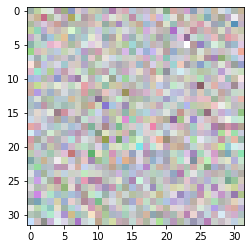

In [ ]:
image_shape = (32, 32, 4)  # 32 x 32 RGBA image

glow = tfb.Glow(output_shape=image_shape,
                coupling_bijector_fn=tfb.GlowDefaultNetwork,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork)

pz = tfd.Sample(tfd.Normal(0., 1.), tf.reduce_prod(image_shape))

# Calling glow on distribution p(z) creates our glow distribution over images.
px = glow(pz)

# Take samples from the distribution to get images from your dataset.
image = px.sample(1)[0].numpy()

# Rescale to [0, 1].
image = (image - image.min()) / (image.max() - image.min())
plt.imshow(image);

### `RayleighCDF`

Bijector for the [Rayleigh distribution's](https://en.wikipedia.org/wiki/Rayleigh_distribution) CDF. One use is sampling from the Rayleigh distribution, by taking uniform samples, then passing them through the inverse of the CDF.

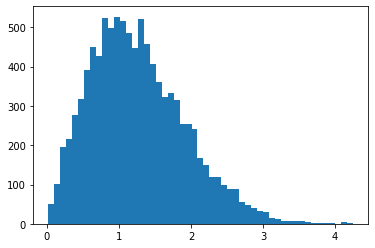

In [ ]:
bij = tfb.RayleighCDF()
uniforms = tfd.Uniform().sample(10_000)
plt.hist(bij.inverse(uniforms), bins='auto');

### `Ascending()` replaces `Invert(Ordered())`

In [ ]:
x = tfd.Normal(0., 1.).sample(5)
print(tfb.Ascending()(x))
print(tfb.Invert(tfb.Ordered())(x))

tf.Tensor([1.9363368 2.650928  3.4936204 4.1817293 5.6920815], shape=(5,), dtype=float32)
Instructions for updating:
`Ordered` bijector is deprecated; please use `tfb.Invert(tfb.Ascending())` instead.
tf.Tensor([1.9363368 2.650928  3.4936204 4.1817293 5.6920815], shape=(5,), dtype=float32)


### Add `low` arg: `Softplus(low=2.)`

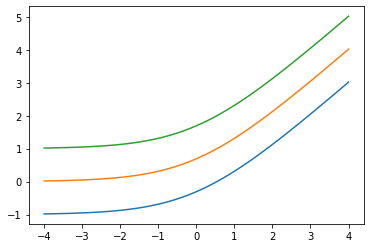

In [ ]:
x = tf.linspace(-4., 4., 100)

for low in (-1., 0., 1.):
  bij = tfb.Softplus(low=low)
  plt.plot(x, bij(x));

### `tfb.ScaleMatvecLinearOperatorBlock` supports blockwise `LinearOperator`, multi-part args

In [ ]:
op_1 = tf.linalg.LinearOperatorDiag(diag=[1., -1., 3.])
op_2 = tf.linalg.LinearOperatorFullMatrix([[12., 5.], [-1., 3.]])
scale = tf.linalg.LinearOperatorBlockDiag([op_1, op_2], is_non_singular=True)

bij = tfb.ScaleMatvecLinearOperatorBlock(scale)
bij([[1., 2., 3.], [0., 1.]])

Instructions for updating:
Do not call `graph_parents`.


[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1., -2.,  9.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5., 3.], dtype=float32)>]

## Distributions

### `Skellam`

Distribution over differences of two `Poisson` RVs.   Note that samples from this distribution can be negative.

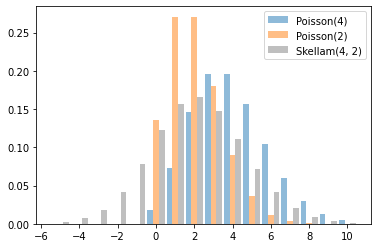

In [ ]:
x = tf.linspace(-5., 10., 10 - -5 + 1)

rates = (4, 2)
for i, rate in enumerate(rates):
  plt.bar(x - .3 * (1 - i), tfd.Poisson(rate).prob(x), label=f'Poisson({rate})', alpha=0.5, width=.3)
plt.bar(x.numpy() + .3, tfd.Skellam(*rates).prob(x).numpy(), color='k', alpha=0.25, width=.3,
        label=f'Skellam{rates}')

plt.legend();

### `JointDistributionCoroutine[AutoBatched]` produce `namedtuple`-like samples

Explicitly specify `sample_dtype=[...]` for the old `tuple` behavior.

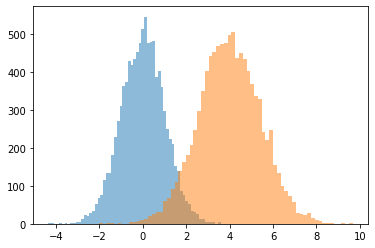

In [ ]:
@tfd.JointDistributionCoroutineAutoBatched
def model():
  x = yield tfd.Normal(0., 1., name='x')
  y = x + 4.
  yield tfd.Normal(y, 1., name='y')

draw = model.sample(10_000)

plt.hist(draw.x, bins='auto', alpha=0.5)
plt.hist(draw.y, bins='auto', alpha=0.5);

### `VonMisesFisher` supports `dim > 5`, `entropy()`

The [von Mises-Fisher distribution](https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution) is a distribution on the $n-1$ dimensional sphere in $\mathbb{R}^n$.

In [ ]:
dist = tfd.VonMisesFisher([0., 1, 0, 1, 0, 1], concentration=1.)
draws = dist.sample(3)

print(dist.entropy())
tf.reduce_sum(draws ** 2, axis=1)  # each draw has length 1

tf.Tensor(3.3533673, shape=(), dtype=float32)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.0000002 , 0.99999994, 1.0000001 ], dtype=float32)>

### `ExpGamma`, `ExpInverseGamma`

`log_rate` parameter added to `Gamma`.
Numerical improvements when sampling low-concentration `Beta`, `Dirichlet` & friends. Implicit reparameterization gradients in all cases.

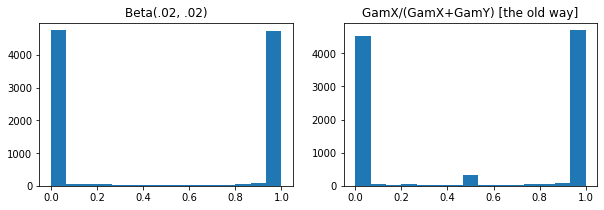

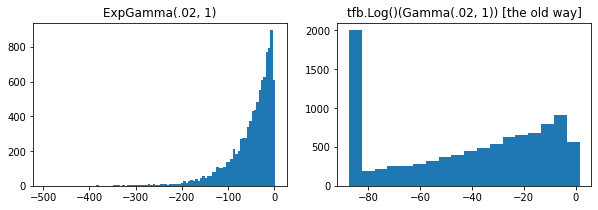

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.hist(tfd.Beta(.02, .02).sample(10_000), bins='auto')
plt.title('Beta(.02, .02)')
plt.subplot(122)
plt.title('GamX/(GamX+GamY) [the old way]')
g = tfd.Gamma(.02, 1); s0, s1 = g.sample(10_000), g.sample(10_000)
plt.hist(s0 / (s0 + s1), bins='auto')
plt.show()

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.hist(tfd.ExpGamma(.02, 1.).sample(10_000), bins='auto')
plt.title('ExpGamma(.02, 1)')
plt.subplot(122)
plt.hist(tfb.Log()(tfd.Gamma(.02, 1.)).sample(10_000), bins='auto')
plt.title('tfb.Log()(Gamma(.02, 1)) [the old way]');

### `JointDistribution*AutoBatched` support reproducible sampling (with length-2 tuple/Tensor seeds)

In [ ]:
@tfd.JointDistributionCoroutineAutoBatched
def model():
  x = yield tfd.Normal(0, 1, name='x')
  y = yield tfd.Normal(x + 4, 1, name='y')

print(model.sample(seed=(1, 2)))
print(model.sample(seed=(1, 2)))

StructTuple(
  x=<tf.Tensor: shape=(), dtype=float32, numpy=-0.59835213>,
  y=<tf.Tensor: shape=(), dtype=float32, numpy=6.2380724>
)
StructTuple(
  x=<tf.Tensor: shape=(), dtype=float32, numpy=-0.59835213>,
  y=<tf.Tensor: shape=(), dtype=float32, numpy=6.2380724>
)


### `KL(VonMisesFisher || SphericalUniform)`


In [ ]:
# Build vMFs with the same mean direction, batch of increasing concentrations.
vmf = tfd.VonMisesFisher(tf.math.l2_normalize(tf.random.normal([10])),
                         concentration=[0., .1, 1., 10.])
# KL increases with concentration, since vMF(conc=0) == SphericalUniform.
print(tfd.kl_divergence(vmf, tfd.SphericalUniform(10)))

tf.Tensor([4.7683716e-07 4.9877167e-04 4.9384594e-02 2.4844694e+00], shape=(4,), dtype=float32)


### `parameter_properties`

Distribution classes now expose a `parameter_properties(dtype=tf.float32, num_classes=None)` class method, which can enable automated construction of many classes of distributions.

In [ ]:
print('Gamma:', tfd.Gamma.parameter_properties())
print('Categorical:', tfd.Categorical.parameter_properties(dtype=tf.float64, num_classes=7))

Gamma: {'concentration': ParameterProperties(event_ndims=0, shape_fn=<function ParameterProperties.<lambda> at 0x7ff6bbfcdd90>, default_constraining_bijector_fn=<function Gamma._parameter_properties.<locals>.<lambda> at 0x7ff6afd95510>, is_preferred=True), 'rate': ParameterProperties(event_ndims=0, shape_fn=<function ParameterProperties.<lambda> at 0x7ff6bbfcdd90>, default_constraining_bijector_fn=<function Gamma._parameter_properties.<locals>.<lambda> at 0x7ff6afd95ea0>, is_preferred=False), 'log_rate': ParameterProperties(event_ndims=0, shape_fn=<function ParameterProperties.<lambda> at 0x7ff6bbfcdd90>, default_constraining_bijector_fn=<class 'tensorflow_probability.python.bijectors.identity.Identity'>, is_preferred=True)}
Categorical: {'logits': ParameterProperties(event_ndims=1, shape_fn=<function Categorical._parameter_properties.<locals>.<lambda> at 0x7ff6afd95510>, default_constraining_bijector_fn=<class 'tensorflow_probability.python.bijectors.identity.Identity'>, is_preferred=

### `experimental_default_event_space_bijector`

Now accepts additional args pinning some distribution parts.

In [ ]:
@tfd.JointDistributionCoroutineAutoBatched
def model():
  scale = yield tfd.Gamma(1, 1, name='scale')
  obs = yield tfd.Normal(0, scale, name='obs')

model.experimental_default_event_space_bijector(obs=.2).forward(
    [tf.random.uniform([3], -2, 2.)])

StructTuple(
  scale=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.6630705, 1.5401832, 1.0777743], dtype=float32)>
)

### `JointDistribution.experimental_pin`

Pins some joint distribution parts, returning `JointDistributionPinned` object representing the joint unnormalized density. 

Working with the `experimental_default_event_space_bijector`, this makes doing variational inference or MCMC with sensible defaults much more straightforward. In the below example, the first two lines of `sample` make running MCMC a breeze.

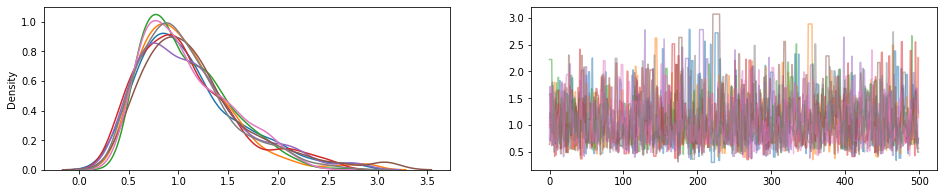

In [ ]:
dist = tfd.JointDistributionSequential([
    tfd.HalfNormal(1.),
    lambda scale: tfd.Normal(0., scale, name='observed')])

@tf.function
def sample():
  bij = dist.experimental_default_event_space_bijector(observed=1.)
  target_log_prob = dist.experimental_pin(observed=1.).unnormalized_log_prob

  kernel = tfp.mcmc.TransformedTransitionKernel(
      tfp.mcmc.HamiltonianMonteCarlo(target_log_prob,
                                     step_size=0.6,
                                     num_leapfrog_steps=16),
      bijector=bij)
  return tfp.mcmc.sample_chain(500, 
                               current_state=tf.ones([8]),  # multiple chains
                               kernel=kernel,
                               trace_fn=None)

draws = sample()

fig, (hist, trace) = plt.subplots(ncols=2, figsize=(16, 3))
trace.plot(draws, alpha=0.5)
for col in tf.transpose(draws):
  sns.kdeplot(col, ax=hist);

### `tfd.NegativeBinomial.experimental_from_mean_dispersion`
Alternative parameterization. Email tfprobability@tensorflow.org or send us a PR to add similar class methods for other distributions.

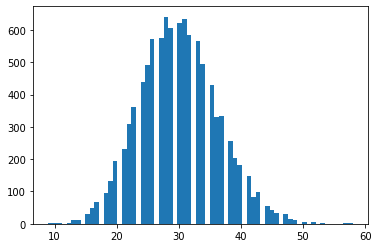

In [ ]:
nb = tfd.NegativeBinomial.experimental_from_mean_dispersion(30., .01)
plt.hist(nb.sample(10_000), bins='auto');

### `tfp.experimental.distribute`

`DistributionStrategy`-aware joint distributions, allowing for cross-device likelihood computations. Sharded `Independent` and `Sample` distributions.

In [ ]:
# Note: 2-logical devices are configured in the install/import cell at top.
strategy = tf.distribute.MirroredStrategy()
assert strategy.num_replicas_in_sync == 2

@tfp.experimental.distribute.JointDistributionCoroutine
def model():
  root = tfp.experimental.distribute.JointDistributionCoroutine.Root
  group_scale = yield root(tfd.Sample(tfd.Exponential(1), 3, name='group_scale'))
  _ = yield tfp.experimental.distribute.ShardedSample(tfd.Independent(tfd.Normal(0, group_scale), 1),
                                                      sample_shape=[4], name='x')

seed1, seed2 = tfp.random.split_seed((1, 2))

@tf.function
def sample(seed):
  return model.sample(seed=seed)
xs = strategy.run(sample, (seed1,))
print("""
Note that the global latent `group_scale` is shared across devices, whereas
the local `x` is sampled independently on each device.
""")
print('sample:', xs)
print('another sample:', strategy.run(sample, (seed2,)))

@tf.function
def log_prob(x):
  return model.log_prob(x)
print("""
Note that each device observes the same log_prob (local latent log_probs are
summed across devices).
""")
print('log_prob:', strategy.run(log_prob, (xs,)))

@tf.function
def grad_log_prob(x):
  return tfp.math.value_and_gradient(model.log_prob, x)[1]

print("""
Note that each device observes the same log_prob gradient (local latents have
independent gradients, global latents have gradients aggregated across devices).
""")
print('grad_log_prob:', strategy.run(grad_log_prob, (xs,)))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1')

Note that the global latent `group_scale` is shared across devices, whereas 
the local `x` is sampled independently on each device.

sample: StructTuple(
  group_scale=PerReplica:{
      0: <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.6355493, 1.1805456, 1.245112 ], dtype=float32)>,
      1: <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.6355493, 1.1805456, 1.245112 ], dtype=float32)>
    },
  x=PerReplica:{
      0: <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
    array([[-0.90548456,  0.7675636 ,  0.27627748],
           [-0.3475989 ,  2.0194046 , -1.2531326 ]], dtype=float32)>,
      1: <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
    array([[ 3.251305  , -0.5790973 ,  0.42745453],
           [-1.562331  ,  0.3006323 ,  0.635732  ]], dtype=float32)>
    }
)
another sample: StructTuple(
  group_scale=PerReplica:{
 

## PSD Kernels

### `GeneralizedMatern`

The `GeneralizedMatern` positive-semidefinite kernel generalizes `MaternOneHalf`, `MAterhThreeHalves`, and `MaternFiveHalves`.



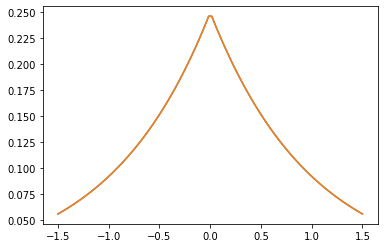

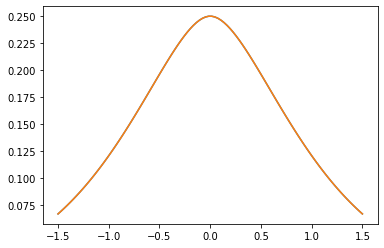

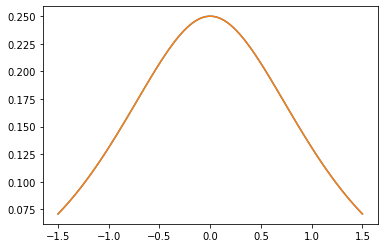

In [ ]:
gm = tfpk.GeneralizedMatern(df=[0.5, 1.5, 2.5], length_scale=1., amplitude=0.5)
m1 = tfpk.MaternOneHalf(length_scale=1., amplitude=0.5)
m2 = tfpk.MaternThreeHalves(length_scale=1., amplitude=0.5)
m3 = tfpk.MaternFiveHalves(length_scale=1., amplitude=0.5)
xs = tf.linspace(-1.5, 1.5, 100)

gm_matrix = gm.matrix([[0.]], xs[..., tf.newaxis])
plt.plot(xs, gm_matrix[0][0])
plt.plot(xs, m1.matrix([[0.]], xs[..., tf.newaxis])[0])
plt.show()
plt.plot(xs, gm_matrix[1][0])
plt.plot(xs, m2.matrix([[0.]], xs[..., tf.newaxis])[0])
plt.show()
plt.plot(xs, gm_matrix[2][0])
plt.plot(xs, m3.matrix([[0.]], xs[..., tf.newaxis])[0])
plt.show()

### `Parabolic` (Epanechnikov)

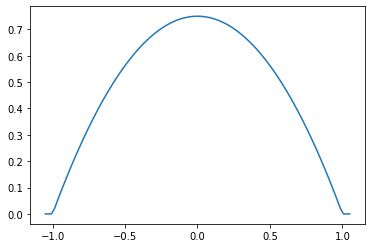

In [ ]:
epa = tfpk.Parabolic()
xs = tf.linspace(-1.05, 1.05, 100)
plt.plot(xs, epa.matrix([[0.]], xs[..., tf.newaxis])[0]);

## VI


### `build_asvi_surrogate_posterior`
Automatically construct a structured surrogate posterior for VI in a way that incorporates the graphical structure of the prior distribution. This utilizes the method described in the paper Automatic Structured Variational Inference (https://arxiv.org/abs/2002.00643).

In [ ]:
# Import a Brownian Motion model from TFP's inference gym.
model = gym.targets.BrownianMotionMissingMiddleObservations()
prior = model.prior_distribution()
ground_truth = ground_truth = model.sample_transformations['identity'].ground_truth_mean
target_log_prob = lambda *values: model.log_likelihood(values) + prior.log_prob(values)

This models a Brownian Motion process with a Gaussian observation model. It consists of 30 timesteps, but the middle 10 timesteps are unobservable.

  ```
  locs[0] ~ Normal(loc=0, scale=innovation_noise_scale)
  for t in range(1, num_timesteps):
    locs[t] ~ Normal(loc=locs[t - 1], scale=innovation_noise_scale)

  for t in range(num_timesteps):
    observed_locs[t] ~ Normal(loc=locs[t], scale=observation_noise_scale)
  ```

 The goal is to infer the values of `locs` from noisy observations (`observed_locs`). Since the middle 10 timesteps are unobservable, `observed_locs` are `NaN` values at timesteps [10,19]. 

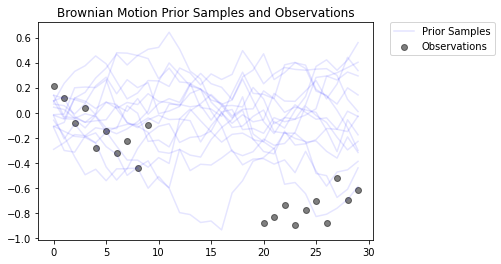

In [ ]:
# The observed loc values in the Brownian Motion inference gym model
OBSERVED_LOC = np.array([
    0.21592641, 0.118771404, -0.07945447, 0.037677474, -0.27885845, -0.1484156,
    -0.3250906, -0.22957903, -0.44110894, -0.09830782, np.nan, np.nan, np.nan,
    np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -0.8786016,
    -0.83736074, -0.7384849, -0.8939254, -0.7774566, -0.70238715, -0.87771565,
    -0.51853573, -0.6948214, -0.6202789
]).astype(dtype=np.float32)

# Plot the prior and the likelihood observations
plt.figure()
plt.title('Brownian Motion Prior Samples and Observations')

num_samples = 15
prior_samples = prior.sample(num_samples)

plt.plot(prior_samples, c='blue', alpha=0.1)
plt.plot(prior_samples[0][0], label="Prior Samples", c='blue', alpha=0.1)

plt.scatter(x=range(30),y=OBSERVED_LOC, c='black', alpha=0.5, label="Observations")

plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress pfor warnings

# Construct and train an ASVI Surrogate Posterior.
asvi_surrogate_posterior = tfp.experimental.vi.build_asvi_surrogate_posterior(prior)

asvi_losses = tfp.vi.fit_surrogate_posterior(target_log_prob,
                                        asvi_surrogate_posterior,
                                        optimizer=tf.optimizers.Adam(learning_rate=0.1),
                                        num_steps=500)
logging.getLogger('tensorflow').setLevel(logging.NOTSET)

In [ ]:
# Construct and train a Mean-Field Surrogate Posterior.
factored_surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(event_shape=prior.event_shape)

factored_losses = tfp.vi.fit_surrogate_posterior(target_log_prob,
                                        factored_surrogate_posterior,
                                        optimizer=tf.optimizers.Adam(learning_rate=0.1),
                                        num_steps=500)

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress pfor warnings

# Sample from the posteriors.
asvi_posterior_samples = asvi_surrogate_posterior.sample(num_samples)
factored_posterior_samples = factored_surrogate_posterior.sample(num_samples)

logging.getLogger('tensorflow').setLevel(logging.NOTSET)

Both the ASVI and the mean-field surrogate posterior distributions have converged, and the ASVI surrogate posterior had a lower final loss (negative ELBO value).

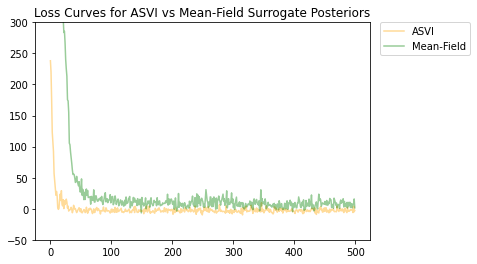

In [ ]:
# Plot the loss curves.
plt.figure()
plt.title('Loss Curves for ASVI vs Mean-Field Surrogate Posteriors')

plt.plot(asvi_losses, c='orange', label='ASVI', alpha = 0.4)
plt.plot(factored_losses, c='green', label='Mean-Field', alpha = 0.4)
plt.ylim(-50, 300)

plt.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.);

The samples from the posteriors highlight how nicely the ASVI surrogate posterior captures the uncertainty for the timesteps without observations. On the other hand, the mean-field surrogate posterior struggles to capture the true uncertainty.

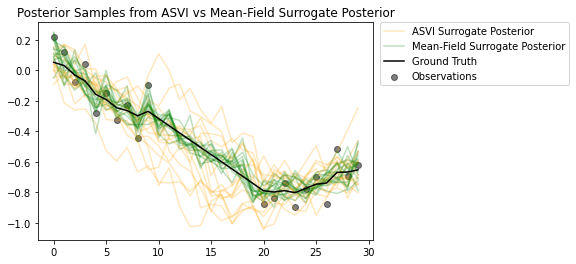

In [ ]:
# Plot samples from the ASVI and Mean-Field Surrogate Posteriors.
plt.figure()
plt.title('Posterior Samples from ASVI vs Mean-Field Surrogate Posterior')

plt.plot(asvi_posterior_samples, c='orange', alpha = 0.25)
plt.plot(asvi_posterior_samples[0][0], label='ASVI Surrogate Posterior', c='orange', alpha = 0.25)

plt.plot(factored_posterior_samples, c='green', alpha = 0.25)
plt.plot(factored_posterior_samples[0][0], label='Mean-Field Surrogate Posterior', c='green', alpha = 0.25)

plt.scatter(x=range(30),y=OBSERVED_LOC, c='black', alpha=0.5, label='Observations')

plt.plot(ground_truth, c='black', label='Ground Truth')

plt.legend(bbox_to_anchor=(1.585, 1), borderaxespad=0.);

## MCMC

### `ProgressBarReducer`
Visualize progress of the sampler. (May have a nominal performance penalty; not currently supported under JIT compilation.)

 99%|█████████▉| 99/100 [00:03<00:00, 27.37it/s]


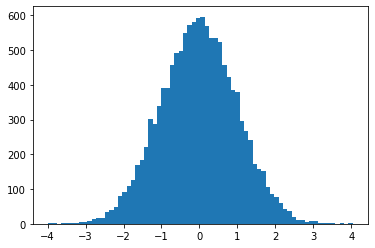

In [ ]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(lambda x: -x**2 / 2, .05, 20)
pbar = tfp.experimental.mcmc.ProgressBarReducer(100)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)
plt.hist(tf.reshape(tfp.mcmc.sample_chain(100, current_state=tf.ones([128]), kernel=kernel, trace_fn=None), [-1]), bins='auto')
pbar.bar.close()

### `sample_sequential_monte_carlo` supports reproducible sampling

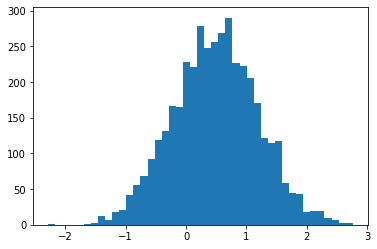

tf.Tensor(
[ 0.665834    0.9892149   0.7961128   1.0016634  -1.000767   -0.19461267
  1.3070581   1.127177    0.9940303   0.58239716], shape=(10,), dtype=float32)
different: tf.Tensor(
[ 1.3284367   0.4374407   1.1349089   0.4557473   0.06510283 -0.08954388
  1.1735026   0.8170528   0.12443061  0.34413314], shape=(10,), dtype=float32)
same: tf.Tensor(
[ 0.665834    0.9892149   0.7961128   1.0016634  -1.000767   -0.19461267
  1.3070581   1.127177    0.9940303   0.58239716], shape=(10,), dtype=float32)


In [ ]:
initial_state = tf.random.uniform([4096], -2., 2.)
def smc(seed):
  return tfp.experimental.mcmc.sample_sequential_monte_carlo(
    prior_log_prob_fn=lambda x: -x**2 / 2,
    likelihood_log_prob_fn=lambda x: -(x-1.)**2 / 2,
    current_state=initial_state,
    seed=seed)[1]
plt.hist(smc(seed=(12, 34)), bins='auto');plt.show()

print(smc(seed=(12, 34))[:10])
print('different:', smc(seed=(10, 20))[:10])
print('same:', smc(seed=(12, 34))[:10])

### Added streaming computations of variance, covariance, Rhat
Note, the interfaces to these have changed somewhat in `tfp-nightly`.

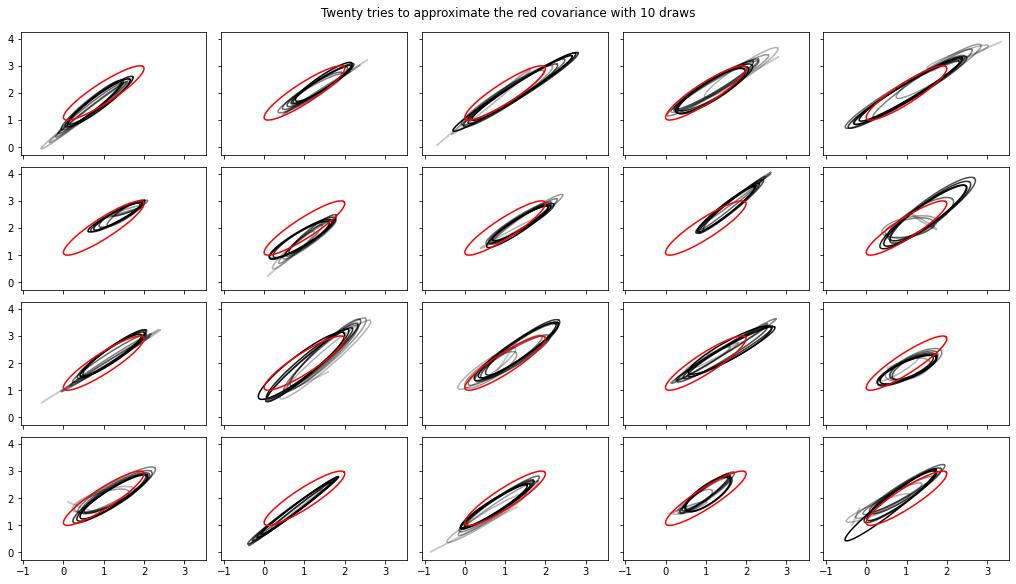

In [ ]:
def cov_to_ellipse(t, cov, mean):
  """Draw a one standard deviation ellipse from the mean, according to cov."""
  diag = tf.linalg.diag_part(cov)
  a = 0.5 * tf.reduce_sum(diag)
  b = tf.sqrt(0.25 * (diag[0] - diag[1])**2 + cov[0, 1]**2)
  major = a + b
  minor = a - b
  theta = tf.math.atan2(major - cov[0, 0], cov[0, 1])
  x = (tf.sqrt(major) * tf.cos(theta) * tf.cos(t) -
       tf.sqrt(minor) * tf.sin(theta) * tf.sin(t))
  y = (tf.sqrt(major) * tf.sin(theta) * tf.cos(t) +
       tf.sqrt(minor) * tf.cos(theta) * tf.sin(t))
  return x + mean[0], y + mean[1]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 8), 
                         sharex=True, sharey=True, constrained_layout=True)
t = tf.linspace(0., 2 * np.pi, 200)
tot = 10
cov = 0.1 * tf.eye(2) + 0.9 * tf.ones([2, 2])
mvn = tfd.MultivariateNormalTriL(loc=[1., 2.],
                                 scale_tril=tf.linalg.cholesky(cov))

for ax in axes.ravel():
  rv = tfp.experimental.stats.RunningCovariance(
      num_samples=0., mean=tf.zeros(2), sum_squared_residuals=tf.zeros((2, 2)),
      event_ndims=1)

  for idx, x in enumerate(mvn.sample(tot)):
    rv = rv.update(x)
    ax.plot(*cov_to_ellipse(t, rv.covariance(), rv.mean),
            color='k', alpha=(idx + 1) / tot)
  ax.plot(*cov_to_ellipse(t, mvn.covariance(), mvn.mean()), 'r')
fig.suptitle("Twenty tries to approximate the red covariance with 10 draws");

## Math, stats

### Bessel functions: ive, kve, log-ive

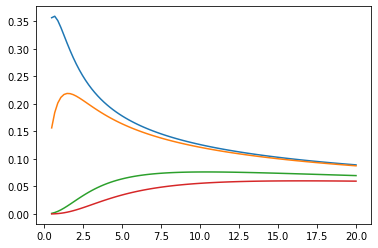

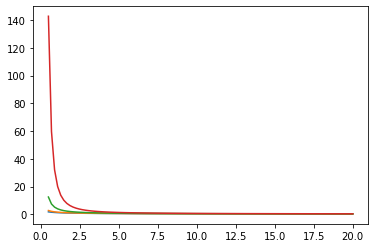

In [ ]:
xs = tf.linspace(0.5, 20., 100)
ys = tfp.math.bessel_ive([[0.5], [1.], [np.pi], [4.]], xs)
zs = tfp.math.bessel_kve([[0.5], [1.], [2.], [np.pi]], xs)

for i in range(4):
  plt.plot(xs, ys[i])
plt.show()

for i in range(4):
  plt.plot(xs, zs[i])
plt.show()

### Optional `weights` arg to `tfp.stats.histogram`

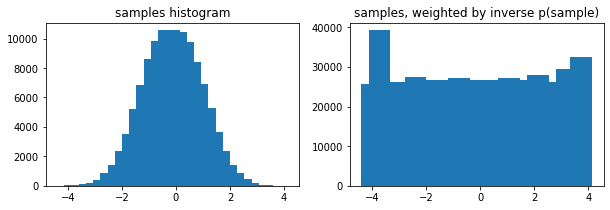

In [ ]:
edges = tf.linspace(-4., 4, 31)
samps = tfd.TruncatedNormal(0, 1, -4, 4).sample(100_000, seed=(123, 456))
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.bar(edges[:-1], tfp.stats.histogram(samps, edges))
ax1.set_title('samples histogram')
ax2.bar(edges[:-1], tfp.stats.histogram(samps, edges, weights=1 / tfd.Normal(0, 1).prob(samps)))
ax2.set_title('samples, weighted by inverse p(sample)');

### `tfp.math.erfcinv`

In [ ]:
x = tf.linspace(-3., 3., 10)
y = tf.math.erfc(x)
z = tfp.math.erfcinv(y)
print(x)
print(z)

tf.Tensor(
[-3.         -2.3333333  -1.6666666  -1.         -0.33333325  0.3333335
  1.          1.666667    2.3333335   3.        ], shape=(10,), dtype=float32)
tf.Tensor(
[-3.0002644  -2.3333426  -1.6666666  -0.9999997  -0.3333332   0.33333346
  0.9999999   1.6666667   2.3333335   3.0000002 ], shape=(10,), dtype=float32)
